In [ ]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST, CIFAR100
from torchvision import transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data = FashionMNIST('data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = FashionMNIST('data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class Control(nn.Module):
    def __init__(self):
        super(Control, self).__init__()

        self.conv1A = nn.Conv2d(1, 100, 3, 1, 1, bias=True)
        self.conv1B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv1C = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 14x14
        self.conv2A = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 7x7
        self.neuron_out = nn.Linear(7*7*200, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)
        x = self.conv1B(x)
        x = self.LRelu(x)
        x = self.conv1C(x)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.LRelu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
control_model = Control().to(device)

In [ ]:
summary(control_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 28, 28]           1,000
         LeakyReLU-2          [-1, 100, 28, 28]               0
            Conv2d-3          [-1, 100, 28, 28]          90,100
         LeakyReLU-4          [-1, 100, 28, 28]               0
            Conv2d-5          [-1, 100, 14, 14]          40,000
         LeakyReLU-6          [-1, 100, 14, 14]               0
            Conv2d-7          [-1, 200, 14, 14]         180,200
         LeakyReLU-8          [-1, 200, 14, 14]               0
            Conv2d-9          [-1, 200, 14, 14]         360,200
        LeakyReLU-10          [-1, 200, 14, 14]               0
           Conv2d-11            [-1, 200, 7, 7]         160,000
        LeakyReLU-12            [-1, 200, 7, 7]               0
           Linear-13                   [-1, 10]          98,010
Total params: 929,510
Trainable params:

In [ ]:
class HeadAttention(torch.nn.Module):

    '''
    Attention Layer might be useful to detect most relevant features in the images.

    Adapted in order to be used with element-wise operations directly to images and feature maps.

    There are weights for the rows(X axis) and for the columns(Y axis). Each weight is applied to the input first in the X axis and then in the Y axis.

    At the end, the result is multiplied in order to get the proper array of weights, where aij = weight map

    So each attention weight is something like this:

      |Aij Bij Cij|
      |Dij Eij Fij|, where Xij = weight x axis * weight y axis
      |Gij Hij Iij|

    Considering that the softmax function has outputs within range [0,1], we can conclude that each weight will be within range [0,1], where 1 is the most important feature.

    OBS: This layer generates small gradients. When stacking too many layers, consider adding residual blocks and skip connections.
    '''

    def __init__(self, input_channels, input_height, input_width):

        super(HeadAttention, self).__init__()

        # Creating array of weights for element-wise operations
        self.x_weights = torch.normal(0, 0.02, size=(input_channels, input_height, input_width), device=device, requires_grad=True)
        self.y_weights = torch.normal(0, 0.02, size=(input_channels, input_height, input_width), device=device, requires_grad=True)

        # Alternative: Create weights with size (channels, height, widt) and multiply over each batch.

        self.batchnorm = torch.nn.BatchNorm2d(input_channels) # To compensate the sqrt(d_key) scaling factor

        #self.softmax = torch.nn.Softmax2d() # Computes softmax over each channel
        self.Xsoftmax = torch.nn.Softmax(-2)
        self.Ysoftmax = torch.nn.Softmax(-1)

    def forward(self, input):

        attention_output = []

        for batch in range(input.size(0)):

            input_data = input[batch] # (Channels, Height, Width)

            x_weights = input_data * self.x_weights
            y_weights = input_data * self.y_weights

            x_weights = self.Xsoftmax(x_weights)
            y_weights = self.Ysoftmax(y_weights)

            attention_weights = x_weights * y_weights # (Channels, Height, Width)

            attention_output.append(attention_weights.unsqueeze(0)) # (1, Channels, Height, Width)

        attention_output = torch.cat(attention_output, 0) # (Batch, Channels, Height, Width)

        attention_output = self.batchnorm(attention_output) # We didn't test with the batchnorm at all. Let's see if this fixes the small gradients problem.

        attention_output = input * attention_output # (Batch, Channels, Height, Width)

        return attention_output

Parâmetros de Controle = 929,510
Parâmetros de Attention Model = 1,568 por attention layer+8000 linear ---> 2 layers e 8 cabeças + linear = 33,088 parâmetros

Quanto mais se adiciona layers ao Attention Model ---> Maior tendência de vanishing gradients

Optimizers padrão: Adam com Learning Rate = 1e-3

**Loss Controle = 11.24**

**Accuracy Controle = 85%**

### **2 Attention layers com 8 cabeças sem BatchNorm:**

Loss Attention = 10.50

Accuracy Attention = 76%

Gradients Average = 4.017644528175879e-07

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.096

Accuracy Attention = 83.82%

Gradients Average = -1.1171219739480875e-05

### **2 Attention layers com 8 cabeças + BatchNorm:**

Loss Attention = 10.35

Accuracy Attention = 76,5%

Gradients Average = 5.872715519217309e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.20

Accuracy Attention = 84.26%

Gradients Average = -6.11864879829227e-06

### **2 Attention layers com 16 cabeças sem BatchNorm:**

Loss Attention = 10.40

Accuracy Attention = 75.74%

Gradients Average = -1.1773558981076349e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 5.66

Accuracy Attention = 84,80%

Gradients Average = -1.1054026799683925e-05

### **2 Attention layers com 16 cabeças + BatchNorm:**

Loss Attention = 10.96

Accuracy Attention = 75,2%

Gradients Average = 9.777439117897302e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.21

Accuracy Attention = 84,35%

Gradients Average = 0.00016451669216621667

### **4 Attention layers com 8 cabeças sem BatchNorm:**

Loss Attention = 9.64

Accuracy Attention = 77,78%

Gradients Average = -1.501455926700146e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.63

Accuracy Attention = 81.74%

Gradients Average = -0.00014806599938310683

### **4 Attention layers com 8 cabeças + BatchNorm:**

Loss Attention = 9.8

Accuracy Attention = 77.62%

Gradients Average = 6.498381480923854e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 5.4

Accuracy Attention = 86.1%

Gradients Average = 0.00015074264956638217

### **4 Attention Layers com 16 cabeças sem BatchNorm:**

Loss Attention = 10.26

Accuracy Attention = 76.11%

Gradients Average = -1.2240524256412755e-06

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.04

Accuracy Attention = 84.55%

Gradients Average = -1.7747438505466562e-06

### **4 Attention Layers com 16 cabeças + BatchNorm:**

Loss Attention = 9.64

Accuracy Attention = 77.79%

Gradients Average = -1.0843522431969177e-05

**USANDO LEARNING RATE = 0.1**

Loss Attention = 8.29

Accuracy Attention = 80.82%

Gradients Average = -3.742274202522822e-05

Possíveis vantagens: Menor tempo de treinamento(menos parâmetros) e possibilidade de desempenho similar a Conv2D padrão.

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(1)
        self.attention2 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(1)
        self.attention3 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention3 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm3 = nn.BatchNorm2d(1)
        self.attention4 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention4 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm4 = nn.BatchNorm2d(1)
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention1(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm1(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention2(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm2(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention3[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention3(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm3(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention4[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention4(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm4(attention_output)

        x = self.LRelu(attention_output)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
summary(attention_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Softmax-1               [-1, 28, 28]               0
           Softmax-2               [-1, 28, 28]               0
           Softmax-3               [-1, 28, 28]               0
           Softmax-4               [-1, 28, 28]               0
       BatchNorm2d-5            [-1, 1, 28, 28]               2
     HeadAttention-6            [-1, 1, 28, 28]               0
           Softmax-7               [-1, 28, 28]               0
           Softmax-8               [-1, 28, 28]               0
           Softmax-9               [-1, 28, 28]               0
          Softmax-10               [-1, 28, 28]               0
      BatchNorm2d-11            [-1, 1, 28, 28]               2
    HeadAttention-12            [-1, 1, 28, 28]               0
          Softmax-13               [-1, 28, 28]               0
          Softmax-14               [-1,

In [ ]:
def weights_init(net):

    for n, p in net.named_parameters():

        if 'weight' in n:

            nn.init.normal_(p, 0, 0.02)

        else:

            nn.init.constant_(p, 0.)

In [ ]:
weights_init(control_model)
weights_init(attention_model)

In [ ]:
optimizer_control = torch.optim.Adam(control_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)

control_losses = []
control_accuracies = []
attention_losses = []
attention_accuracies = []

control_gradients = []
attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    control_epoch_loss = 0.
    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        control_model.zero_grad()
        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        control_output = control_model(image)
        attention_output = attention_model(image)

        control_loss = loss(control_output, target)

        control_losses.append(control_loss.item())

        control_epoch_loss += control_loss.item()

        control_loss.backward()

        control_gradients_avg = torch.mean(control_model.conv1A.weight.grad)
        control_gradients.append(control_gradients_avg.cpu())

        optimizer_control.step()

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_control = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                control_output = control_model(image)
                attention_output = attention_model(image)

            total += len(target)

            _, control_output = torch.max(control_output, 1)
            _, attention_output = torch.max(attention_output, 1)
            
            correct_control += (control_output == target).sum()
            correct_attention += (attention_output == target).sum()


        control_accuracy = (correct_control/total)*100
        control_accuracies.append(control_accuracy.cpu())

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Control Model Loss: {control_epoch_loss}\tControl Model Accuracy: {control_accuracy}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Control Gradients: {control_gradients[-1]}\tAttention Gradients: {attention_gradients[-1]}")


Text(0.5, 1.0, 'Attention Gradients Average')

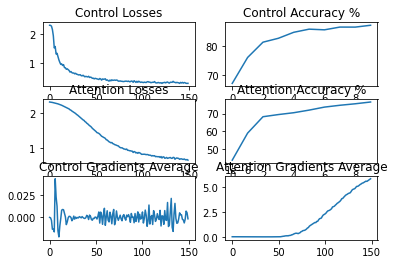

In [ ]:
# 2 layers, 8 heads + BatchNorm

fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

Text(0.5, 1.0, 'Attention Gradients Average')

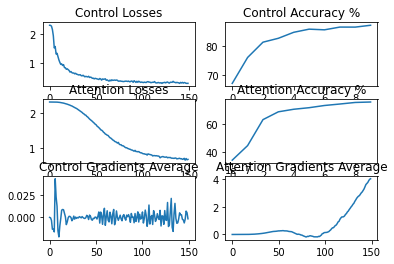

In [ ]:
# 2 layers, 8 heads without BatchNorm

fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

In [ ]:
# Treinando apenas o Attention Model, com LR = 0.1

weights_init(attention_model)

#EPOCHS = 10
EPOCHS = 5 # For plotting outputs ---> 5~8 Epochs provide the best accuracy
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-1, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
# Treinando apenas o Attention Model

for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)
            
            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/5
Attention Model Loss: 30.9317786693573	Attention Model Accuracy: 69.18000030517578
Attention Gradients: 1.9484865276808705e-07
2/5
Attention Model Loss: 12.95476496219635	Attention Model Accuracy: 74.53999328613281
Attention Gradients: 7.679609552724287e-05
3/5
Attention Model Loss: 9.603540539741516	Attention Model Accuracy: 79.37999725341797
Attention Gradients: 6.179006595630199e-05


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Attention Gradients Average')

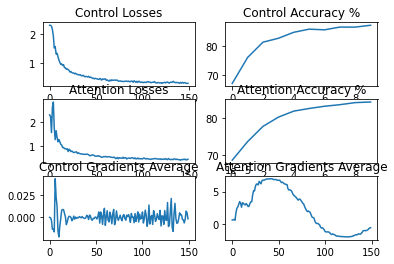

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

Text(0.5, 1.0, 'Attention Gradients Average')

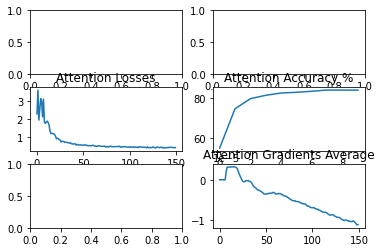

In [ ]:
# Sem BatchNorm

fig, ax = plt.subplots(3,2)

#ax[0,0].plot(torch.arange(0, iters), control_losses)
#ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
#ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
#ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

#ax[2,0].plot(torch.arange(0, iters), control_gradients)
#ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

Text(0.5, 1.0, 'Attention Gradients Average')

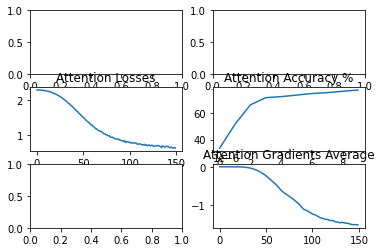

In [ ]:
# 4 layers, 8 heads without BatchNorm

fig, ax = plt.subplots(3,2)

#ax[0,0].plot(torch.arange(0, iters), control_losses)
#ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
#ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
#ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

#ax[2,0].plot(torch.arange(0, iters), control_gradients)
#ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

In [ ]:
# Plotting samples of outputs of each attention layer

class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(1)
        self.attention2 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(1)
        self.attention3 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention3 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm3 = nn.BatchNorm2d(1)
        self.attention4 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention4 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm4 = nn.BatchNorm2d(1)
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output1_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output1_postconv = self.convattention1(attention_output1_preconv) # (Batch, n_channels, Height, Width)

        attention_output1_prenorm = input + attention_output1_postconv # (Batch, n_channels, Height, Width)

        attention_output1_postnorm = self.batchnorm1(attention_output1_prenorm)

        x = self.LRelu(attention_output1_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output2_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output2_postconv = self.convattention2(attention_output2_preconv) # (Batch, n_channels, Height, Width)

        attention_output2_prenorm = input + attention_output2_postconv # (Batch, n_channels, Height, Width)

        attention_output2_postnorm = self.batchnorm2(attention_output2_prenorm)

        x = self.LRelu(attention_output2_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention3[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output3_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output3_postconv = self.convattention3(attention_output3_preconv) # (Batch, n_channels, Height, Width)

        attention_output3_prenorm = input + attention_output3_postconv # (Batch, n_channels, Height, Width)

        attention_output3_postnorm = self.batchnorm3(attention_output3_prenorm)

        x = self.LRelu(attention_output3_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention4[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output4_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output4_postconv = self.convattention4(attention_output4_preconv) # (Batch, n_channels, Height, Width)

        attention_output4_prenorm = input + attention_output4_postconv # (Batch, n_channels, Height, Width)

        attention_output4_postnorm = self.batchnorm4(attention_output4_prenorm)

        x = self.LRelu(attention_output4_postnorm)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        attention_outputs = [
            attention_output1_preconv, attention_output1_postconv, attention_output1_prenorm, attention_output1_postnorm,
            attention_output2_preconv, attention_output2_postconv, attention_output2_prenorm, attention_output2_postnorm,
            attention_output3_preconv, attention_output3_postconv, attention_output3_prenorm, attention_output3_postnorm,
            attention_output4_preconv, attention_output4_postconv, attention_output4_prenorm, attention_output4_postnorm
        ]

        return output, attention_outputs

In [ ]:
torch.save(attention_model.state_dict(), 'Attention_params.tar')

In [ ]:
visual_model = AttentionModel(8).to(device)

visual_model.load_state_dict(torch.load("Attention_params.tar"))

<All keys matched successfully>

In [ ]:
def to_numpy(tensor):

    #tensor = tensor.view(tensor.size(0), tensor.size(2), tensor.size(3), tensor.size(1)) This one breaks RGB images, since transform.ToTensor uses .permute()
    tensor = tensor.permute(0, 2, 3, 1)
    tensor = tensor.detach().cpu().numpy()
    tensor = (tensor+1.0)*0.5
    
    return tensor

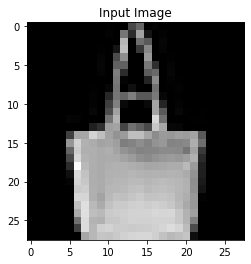

In [ ]:
import matplotlib.pyplot as plt

visual_model.eval()

image, target = next(iter(train_loader))

image, target = image.to(device), target.to(device)

output, attention_outputs = visual_model(image)

image = to_numpy(image)

attention_output1_preconv, attention_output1_postconv = to_numpy(attention_outputs[0]), to_numpy(attention_outputs[1])
attention_output1_prenorm, attention_output1_postnorm = to_numpy(attention_outputs[2]), to_numpy(attention_outputs[3])

attention_output2_preconv, attention_output2_postconv = to_numpy(attention_outputs[4]), to_numpy(attention_outputs[5])
attention_output2_prenorm, attention_output2_postnorm = to_numpy(attention_outputs[6]), to_numpy(attention_outputs[7])

attention_output3_preconv, attention_output3_postconv = to_numpy(attention_outputs[8]), to_numpy(attention_outputs[9])
attention_output3_prenorm, attention_output3_postnorm = to_numpy(attention_outputs[10]), to_numpy(attention_outputs[11])

attention_output4_preconv, attention_output4_postconv = to_numpy(attention_outputs[12]), to_numpy(attention_outputs[13])
attention_output4_prenorm, attention_output4_postnorm = to_numpy(attention_outputs[14]), to_numpy(attention_outputs[15])

plt.imshow(image[0].squeeze(-1), cmap='gray') # Matplotlib expects a channel dimension with 3 or 4 channels, not 1.
plt.title("Input Image")
plt.show()

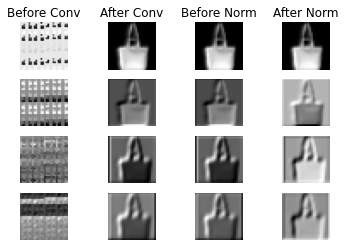

In [ ]:
# Visualizing Attention Outputs

fig, ax = plt.subplots(4, 4)

for x in range(4):
    for y in range(4):
        ax[x,y].axis("off")

ax[0, 0].imshow(attention_output1_preconv[0, :, :, 0], cmap='gray') # Attention: This one's shape is (Batch, Height, Width, n_heads*n_channels)
ax[0, 0].set_title("Before Conv")
ax[0, 1].imshow(attention_output1_postconv[0].squeeze(-1), cmap='gray')
ax[0, 1].set_title("After Conv")
ax[0, 2].imshow(attention_output1_prenorm[0].squeeze(-1), cmap='gray')
ax[0, 2].set_title("Before Norm")
ax[0, 3].imshow(attention_output1_postnorm[0].squeeze(-1), cmap='gray')
ax[0, 3].set_title("After Norm")
ax[1, 0].imshow(attention_output2_preconv[0, :, :, 0], cmap='gray')
ax[1, 1].imshow(attention_output2_postconv[0].squeeze(-1), cmap='gray')
ax[1, 2].imshow(attention_output2_prenorm[0].squeeze(-1), cmap='gray')
ax[1, 3].imshow(attention_output2_postnorm[0].squeeze(-1), cmap='gray')
ax[2, 0].imshow(attention_output3_preconv[0, :, :, 0], cmap='gray')
ax[2, 1].imshow(attention_output3_postconv[0].squeeze(-1), cmap='gray')
ax[2, 2].imshow(attention_output3_prenorm[0].squeeze(-1), cmap='gray')
ax[2, 3].imshow(attention_output3_postnorm[0].squeeze(-1), cmap='gray')
ax[3, 0].imshow(attention_output4_preconv[0, :, :, 0], cmap='gray')
ax[3, 1].imshow(attention_output4_postconv[0].squeeze(-1), cmap='gray')
ax[3, 2].imshow(attention_output4_prenorm[0].squeeze(-1), cmap='gray')
ax[3, 3].imshow(attention_output4_postnorm[0].squeeze(-1), cmap='gray')

plt.show()


In [ ]:
from torch.utils import tensorboard

writer = tensorboard.SummaryWriter(log_dir='Test')

writer.add_graph(control_model, torch.randn((1, 1, 28, 28), device=device))
writer.add_graph(attention_model, torch.randn((1, 1, 28, 28), device=device))

writer.add_scalar("Control Losses", control_losses)
writer.add_scalar("Attention Losses", attention_losses)
writer.add_scalar("Control Accuracy", control_accuracies)
writer.add_scalar("Attention Accuracy", attention_accuracies)
writer.add_scalar("Control Gradients Average", control_gradients)
writer.add_scalar("Attention Gradients Average", attention_gradients)

writer.close()

# Testing with CIFAR100

In [ ]:
cifar_train = CIFAR100('data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar_test = CIFAR100('data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


(2048, 32, 32, 3)


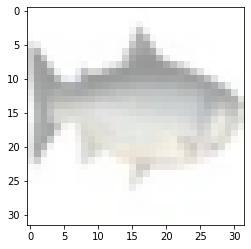

In [ ]:
image, target = next(iter(train_loader))

image = to_numpy(image)

print(image.shape)

plt.imshow(image[25])
plt.show()

In [ ]:
class Control(nn.Module):
    def __init__(self):
        super(Control, self).__init__()

        self.conv1A = nn.Conv2d(3, 100, 3, 1, 1, bias=True) # 32x32
        self.conv1B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv1C = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 16x16
        self.conv2A = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 8x8
        self.neuron_out = nn.Linear(8*8*200, 100, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)
        x = self.conv1B(x)
        x = self.LRelu(x)
        x = self.conv1C(x)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.LRelu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
control_model = Control().to(device)

In [ ]:
summary(control_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
         LeakyReLU-2          [-1, 100, 32, 32]               0
            Conv2d-3          [-1, 100, 32, 32]          90,100
         LeakyReLU-4          [-1, 100, 32, 32]               0
            Conv2d-5          [-1, 100, 16, 16]          40,000
         LeakyReLU-6          [-1, 100, 16, 16]               0
            Conv2d-7          [-1, 200, 16, 16]         180,200
         LeakyReLU-8          [-1, 200, 16, 16]               0
            Conv2d-9          [-1, 200, 16, 16]         360,200
        LeakyReLU-10          [-1, 200, 16, 16]               0
           Conv2d-11            [-1, 200, 8, 8]         160,000
        LeakyReLU-12            [-1, 200, 8, 8]               0
           Linear-13                  [-1, 100]       1,280,100
Total params: 2,113,400
Trainable param

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(3)
        self.attention2 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(3)
        self.attention3 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention3 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm3 = nn.BatchNorm2d(3)
        self.attention4 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention4 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm4 = nn.BatchNorm2d(3)
        self.neuron_out = nn.Linear(3*32*32, 100, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version) ---> Have to be used, since targets must be [0, 1]

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention1(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm1(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention2(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm2(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention3[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention3(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm3(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention4[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention4(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm4(attention_output)

        x = self.LRelu(attention_output)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
summary(attention_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Softmax-1               [-1, 32, 32]               0
           Softmax-2               [-1, 32, 32]               0
           Softmax-3               [-1, 32, 32]               0
           Softmax-4               [-1, 32, 32]               0
       BatchNorm2d-5            [-1, 3, 32, 32]               6
     HeadAttention-6            [-1, 3, 32, 32]               0
           Softmax-7               [-1, 32, 32]               0
           Softmax-8               [-1, 32, 32]               0
           Softmax-9               [-1, 32, 32]               0
          Softmax-10               [-1, 32, 32]               0
      BatchNorm2d-11            [-1, 3, 32, 32]               6
    HeadAttention-12            [-1, 3, 32, 32]               0
          Softmax-13               [-1, 32, 32]               0
          Softmax-14               [-1,

In [ ]:
weights_init(control_model)
weights_init(attention_model)

In [ ]:
optimizer_control = torch.optim.Adam(control_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-1, betas=(0.9, 0.999))

In [ ]:
EPOCHS = 5
iters = 0.

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=2048, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=2048, shuffle=True)

control_losses = []
control_accuracies = []
attention_losses = []
attention_accuracies = []

control_gradients = []
attention_gradients = []

In the control model, using a learning rate greater than 1e-3 prevents the optimizer convergence and leads to losses prone to infinite, with accuracy always 1.0

With the Attention Model, this only makes it reach the performance plateau faster(probably because the Attention Model already generates small gradients).

In [ ]:
for epoch in range(EPOCHS):

    control_epoch_loss = 0.
    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        control_model.zero_grad()
        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        control_output = control_model(image)
        attention_output = attention_model(image)

        control_loss = loss(control_output, target)

        control_losses.append(control_loss.item())

        control_epoch_loss += control_loss.item()

        control_loss.backward()

        control_gradients_avg = torch.mean(control_model.conv1A.weight.grad)
        control_gradients.append(control_gradients_avg.cpu())

        optimizer_control.step()

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_control = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                control_output = control_model(image)
                attention_output = attention_model(image)

            total += len(target)

            _, control_output = torch.max(control_output, 1)
            _, attention_output = torch.max(attention_output, 1)
            
            correct_control += (control_output == target).sum()
            correct_attention += (attention_output == target).sum()


        control_accuracy = (correct_control/total)*100
        control_accuracies.append(control_accuracy.cpu())

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Control Model Loss: {control_epoch_loss}\tControl Model Accuracy: {control_accuracy}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Control Gradients: {control_gradients[-1]}\tAttention Gradients: {attention_gradients[-1]}")


1/5
Control Model Loss: 112.55595016479492	Control Model Accuracy: 5.96999979019165
Attention Model Loss: 195.20296812057495	Attention Model Accuracy: 0.85999995470047
Control Gradients: -0.0016671314369887114	Attention Gradients: -2.4372338884859346e-05
2/5
Control Model Loss: 100.30208563804626	Control Model Accuracy: 11.639999389648438
Attention Model Loss: 161.02204704284668	Attention Model Accuracy: 2.049999952316284
Control Gradients: -0.01330670714378357	Attention Gradients: -2.2135418475954793e-05
3/5
Control Model Loss: 92.05174732208252	Control Model Accuracy: 16.079999923706055
Attention Model Loss: 139.4628357887268	Attention Model Accuracy: 2.059999942779541
Control Gradients: -0.005034144502133131	Attention Gradients: -1.3413955457508564e-05
4/5
Control Model Loss: 87.05439591407776	Control Model Accuracy: 18.889999389648438
Attention Model Loss: 113.61817932128906	Attention Model Accuracy: 6.449999809265137
Control Gradients: 0.003010409651324153	Attention Gradients: -1.

Text(0.5, 1.0, 'Attention Gradients Average')

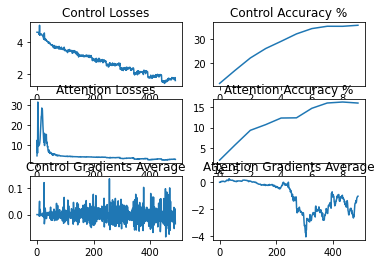

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

In [ ]:
# Treinando apenas o Attention Model

for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)
            
            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/5
Attention Model Loss: 294.63399934768677	Attention Model Accuracy: 0.8299999833106995
Attention Gradients: -3.939494490623474e-05
2/5
Attention Model Loss: 138.0029010772705	Attention Model Accuracy: 1.7699999809265137
Attention Gradients: -3.9135629776865244e-05
3/5
Attention Model Loss: 114.79764223098755	Attention Model Accuracy: 4.099999904632568
Attention Gradients: -3.889690196956508e-05
4/5
Attention Model Loss: 108.07589626312256	Attention Model Accuracy: 7.140000343322754
Attention Gradients: -3.713483965839259e-05
5/5
Attention Model Loss: 104.02251148223877	Attention Model Accuracy: 8.549999237060547
Attention Gradients: -3.451923839747906e-05


In [ ]:
# Treinando apenas o Attention Model - PLOTAR IMAGENS EM SEPARADO PARA GARANTIR Q CONSERVAREMOS OS OUTPUTS DAS CÉLULAS

for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)
            
            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/3
Attention Model Loss: 197.68226623535156	Attention Model Accuracy: 1.149999976158142
Attention Gradients: -1.3999289876664989e-05
2/3
Attention Model Loss: 175.78135013580322	Attention Model Accuracy: 1.1799999475479126
Attention Gradients: -5.55334918317385e-06
3/3
Attention Model Loss: 184.60479259490967	Attention Model Accuracy: 1.9500000476837158
Attention Gradients: -9.572629096510354e-06


In [ ]:
# Plotting samples of outputs of each attention layer

class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(3)
        self.attention2 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(3)
        self.attention3 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention3 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm3 = nn.BatchNorm2d(3)
        self.attention4 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention4 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm4 = nn.BatchNorm2d(3)
        self.neuron_out = nn.Linear(3*32*32, 100, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output1_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output1_postconv = self.convattention1(attention_output1_preconv) # (Batch, n_channels, Height, Width)

        attention_output1_prenorm = input + attention_output1_postconv # (Batch, n_channels, Height, Width)

        attention_output1_postnorm = self.batchnorm1(attention_output1_prenorm)

        x = self.LRelu(attention_output1_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output2_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output2_postconv = self.convattention2(attention_output2_preconv) # (Batch, n_channels, Height, Width)

        attention_output2_prenorm = input + attention_output2_postconv # (Batch, n_channels, Height, Width)

        attention_output2_postnorm = self.batchnorm2(attention_output2_prenorm)

        x = self.LRelu(attention_output2_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention3[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output3_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output3_postconv = self.convattention3(attention_output3_preconv) # (Batch, n_channels, Height, Width)

        attention_output3_prenorm = input + attention_output3_postconv # (Batch, n_channels, Height, Width)

        attention_output3_postnorm = self.batchnorm3(attention_output3_prenorm)

        x = self.LRelu(attention_output3_postnorm)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention4[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output4_preconv = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output4_postconv = self.convattention4(attention_output4_preconv) # (Batch, n_channels, Height, Width)

        attention_output4_prenorm = input + attention_output4_postconv # (Batch, n_channels, Height, Width)

        attention_output4_postnorm = self.batchnorm4(attention_output4_prenorm)

        x = self.LRelu(attention_output4_postnorm)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        attention_outputs = [
            attention_output1_preconv, attention_output1_postconv, attention_output1_prenorm, attention_output1_postnorm,
            attention_output2_preconv, attention_output2_postconv, attention_output2_prenorm, attention_output2_postnorm,
            attention_output3_preconv, attention_output3_postconv, attention_output3_prenorm, attention_output3_postnorm,
            attention_output4_preconv, attention_output4_postconv, attention_output4_prenorm, attention_output4_postnorm
        ]

        return output, attention_outputs

In [ ]:
torch.save(attention_model.state_dict(), 'Attention_params.tar')

In [ ]:
visual_model = AttentionModel(8).to(device)

visual_model.load_state_dict(torch.load("Attention_params.tar"))

<All keys matched successfully>

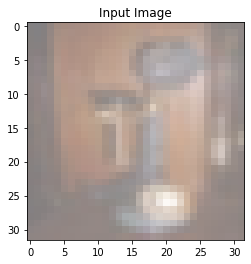

In [ ]:
visual_model.eval()

image, target = next(iter(train_loader))

image, target = image.to(device), target.to(device)

output, attention_outputs = visual_model(image)

image = to_numpy(image)

attention_output1_preconv, attention_output1_postconv = to_numpy(attention_outputs[0]), to_numpy(attention_outputs[1])
attention_output1_prenorm, attention_output1_postnorm = to_numpy(attention_outputs[2]), to_numpy(attention_outputs[3])

attention_output2_preconv, attention_output2_postconv = to_numpy(attention_outputs[4]), to_numpy(attention_outputs[5])
attention_output2_prenorm, attention_output2_postnorm = to_numpy(attention_outputs[6]), to_numpy(attention_outputs[7])

attention_output3_preconv, attention_output3_postconv = to_numpy(attention_outputs[8]), to_numpy(attention_outputs[9])
attention_output3_prenorm, attention_output3_postnorm = to_numpy(attention_outputs[10]), to_numpy(attention_outputs[11])

attention_output4_preconv, attention_output4_postconv = to_numpy(attention_outputs[12]), to_numpy(attention_outputs[13])
attention_output4_prenorm, attention_output4_postnorm = to_numpy(attention_outputs[14]), to_numpy(attention_outputs[15])

plt.imshow(image[0]) # Matplotlib expects a channel dimension with 3 or 4 channels, not 1.
plt.title("Input Image")
plt.show()

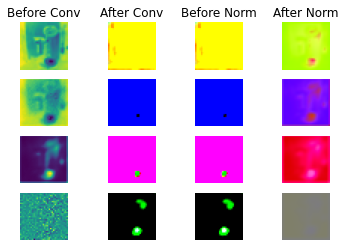

In [ ]:
# Visualizing Attention Outputs

fig, ax = plt.subplots(4, 4)

for x in range(4):
    for y in range(4):
        ax[x,y].axis("off")

ax[0, 0].imshow(attention_output1_preconv[0, :, :, 0]) # Attention: This one's shape is (Batch, Height, Width, n_heads*n_channels)
ax[0, 0].set_title("Before Conv")
ax[0, 1].imshow(attention_output1_postconv[0])
ax[0, 1].set_title("After Conv")
ax[0, 2].imshow(attention_output1_prenorm[0])
ax[0, 2].set_title("Before Norm")
ax[0, 3].imshow(attention_output1_postnorm[0])
ax[0, 3].set_title("After Norm")
ax[1, 0].imshow(attention_output2_preconv[0, :, :, 0])
ax[1, 1].imshow(attention_output2_postconv[0])
ax[1, 2].imshow(attention_output2_prenorm[0])
ax[1, 3].imshow(attention_output2_postnorm[0])
ax[2, 0].imshow(attention_output3_preconv[0, :, :, 0])
ax[2, 1].imshow(attention_output3_postconv[0])
ax[2, 2].imshow(attention_output3_prenorm[0])
ax[2, 3].imshow(attention_output3_postnorm[0])
ax[3, 0].imshow(attention_output4_preconv[0, :, :, 0])
ax[3, 1].imshow(attention_output4_postconv[0])
ax[3, 2].imshow(attention_output4_prenorm[0])
ax[3, 3].imshow(attention_output4_postnorm[0])

plt.show()

In [ ]:
# Checking 

print(attention_model.attention1[0].x_weights)

tensor([[[ 0.0307,  0.0093,  0.0088,  ..., -0.0176, -0.0178,  0.0441],
         [-0.0018, -0.0092, -0.0158,  ..., -0.0240, -0.0175,  0.0309],
         [-0.0142,  0.0072, -0.0008,  ...,  0.0122, -0.0127,  0.0041],
         ...,
         [ 0.0014, -0.0222,  0.0032,  ...,  0.0262,  0.0169, -0.0026],
         [-0.0091,  0.0029,  0.0017,  ...,  0.0166,  0.0024, -0.0009],
         [-0.0183,  0.0093,  0.0170,  ...,  0.0213, -0.0258, -0.0307]],

        [[ 0.0020, -0.0020, -0.0023,  ..., -0.0187, -0.0019, -0.0315],
         [ 0.0079,  0.0305, -0.0104,  ...,  0.0082,  0.0024, -0.0087],
         [ 0.0041,  0.0178,  0.0249,  ...,  0.0154, -0.0230,  0.0058],
         ...,
         [ 0.0033, -0.0165,  0.0079,  ...,  0.0116,  0.0107,  0.0032],
         [-0.0108,  0.0117,  0.0171,  ...,  0.0037, -0.0131, -0.0047],
         [ 0.0218, -0.0005,  0.0002,  ...,  0.0003,  0.0156, -0.0155]],

        [[-0.0348,  0.0048, -0.0330,  ..., -0.0182,  0.0179,  0.0134],
         [ 0.0210,  0.0021,  0.0367,  ...,  0

Curiously, the Attention Model seems to behave differently in each dataset, perhaps because of the different learning rate used.

**In the MNIST**, the Attention head seems to be useless and the true thing really happens in the Convolution.
Every Attention Head, here, seems to simply output random noise, with the Convolution recomposing the image.


**However, in CIFAR100**, the Convolution is what actually seems to prejudice the model's performance.
The First Attention Head, in the worst scenario, would be able to correctly reproduce the input image. In the best scenario, it would be able to properly extract the most relevant features.

The Convolution, while not correctly optimized, appears to be corrupting the image, something that might be mitigated through the concatenation of all attention outputs, with one convolutions distorting less than others.

More or less the same seem to be happening in the next layers. The attention head tries to extract the most relevant features in the image(recomposing the object), yet the Convolution returns just a blank square.

It might be interesting to analyze how the Convolution and the Attention Head behaves after more epochs. It might be possible that their performance is inversely correlated.

In [ ]:
# Checking if the attention head is trying to simply reproduce the input

print(attention_model.attention1[0].x_weights)

tensor([[[ 0.0307,  0.0093,  0.0088,  ..., -0.0176, -0.0178,  0.0441],
         [-0.0018, -0.0092, -0.0158,  ..., -0.0240, -0.0175,  0.0309],
         [-0.0142,  0.0072, -0.0008,  ...,  0.0122, -0.0127,  0.0041],
         ...,
         [ 0.0014, -0.0222,  0.0032,  ...,  0.0262,  0.0169, -0.0026],
         [-0.0091,  0.0029,  0.0017,  ...,  0.0166,  0.0024, -0.0009],
         [-0.0183,  0.0093,  0.0170,  ...,  0.0213, -0.0258, -0.0307]],

        [[ 0.0020, -0.0020, -0.0023,  ..., -0.0187, -0.0019, -0.0315],
         [ 0.0079,  0.0305, -0.0104,  ...,  0.0082,  0.0024, -0.0087],
         [ 0.0041,  0.0178,  0.0249,  ...,  0.0154, -0.0230,  0.0058],
         ...,
         [ 0.0033, -0.0165,  0.0079,  ...,  0.0116,  0.0107,  0.0032],
         [-0.0108,  0.0117,  0.0171,  ...,  0.0037, -0.0131, -0.0047],
         [ 0.0218, -0.0005,  0.0002,  ...,  0.0003,  0.0156, -0.0155]],

        [[-0.0348,  0.0048, -0.0330,  ..., -0.0182,  0.0179,  0.0134],
         [ 0.0210,  0.0021,  0.0367,  ...,  0

In [ ]:
from datetime import datetime


start = datetime.now()
for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)
            
            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")


end = datetime.now()

print(f"{EPOCHS} epochs finished after {end-start}")

1/5
Attention Model Loss: 100.37273907661438	Attention Model Accuracy: 10.559999465942383
Attention Gradients: -2.2811844246461987e-05
2/5
Attention Model Loss: 97.98356699943542	Attention Model Accuracy: 11.180000305175781
Attention Gradients: -2.41814323089784e-05
3/5
Attention Model Loss: 95.96169567108154	Attention Model Accuracy: 12.269999504089355
Attention Gradients: -1.8246244508191012e-05
4/5
Attention Model Loss: 94.13492131233215	Attention Model Accuracy: 12.629999160766602
Attention Gradients: 4.521042683336418e-06
5/5
Attention Model Loss: 91.98274111747742	Attention Model Accuracy: 14.19999885559082
Attention Gradients: 1.4815566828474402e-05
5 finished after 1:01:07.631328


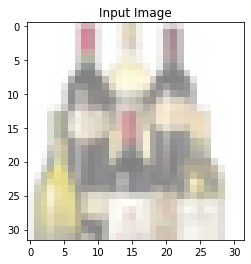

In [ ]:
visual_model.eval()

image, target = next(iter(train_loader))

image, target = image.to(device), target.to(device)

output, attention_outputs = visual_model(image)

image = to_numpy(image)

attention_output1_preconv, attention_output1_postconv = to_numpy(attention_outputs[0]), to_numpy(attention_outputs[1])
attention_output1_prenorm, attention_output1_postnorm = to_numpy(attention_outputs[2]), to_numpy(attention_outputs[3])

attention_output2_preconv, attention_output2_postconv = to_numpy(attention_outputs[4]), to_numpy(attention_outputs[5])
attention_output2_prenorm, attention_output2_postnorm = to_numpy(attention_outputs[6]), to_numpy(attention_outputs[7])

attention_output3_preconv, attention_output3_postconv = to_numpy(attention_outputs[8]), to_numpy(attention_outputs[9])
attention_output3_prenorm, attention_output3_postnorm = to_numpy(attention_outputs[10]), to_numpy(attention_outputs[11])

attention_output4_preconv, attention_output4_postconv = to_numpy(attention_outputs[12]), to_numpy(attention_outputs[13])
attention_output4_prenorm, attention_output4_postnorm = to_numpy(attention_outputs[14]), to_numpy(attention_outputs[15])

plt.imshow(image[0]) # Matplotlib expects a channel dimension with 3 or 4 channels, not 1.
plt.title("Input Image")
plt.show()

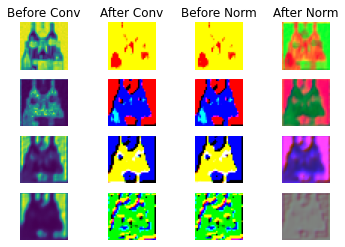

In [ ]:
# Visualizing Attention Outputs

fig, ax = plt.subplots(4, 4)

for x in range(4):
    for y in range(4):
        ax[x,y].axis("off")

ax[0, 0].imshow(attention_output1_preconv[0, :, :, 0]) # Attention: This one's shape is (Batch, Height, Width, n_heads*n_channels)
ax[0, 0].set_title("Before Conv")
ax[0, 1].imshow(attention_output1_postconv[0])
ax[0, 1].set_title("After Conv")
ax[0, 2].imshow(attention_output1_prenorm[0])
ax[0, 2].set_title("Before Norm")
ax[0, 3].imshow(attention_output1_postnorm[0])
ax[0, 3].set_title("After Norm")
ax[1, 0].imshow(attention_output2_preconv[0, :, :, 0])
ax[1, 1].imshow(attention_output2_postconv[0])
ax[1, 2].imshow(attention_output2_prenorm[0])
ax[1, 3].imshow(attention_output2_postnorm[0])
ax[2, 0].imshow(attention_output3_preconv[0, :, :, 0])
ax[2, 1].imshow(attention_output3_postconv[0])
ax[2, 2].imshow(attention_output3_prenorm[0])
ax[2, 3].imshow(attention_output3_postnorm[0])
ax[3, 0].imshow(attention_output4_preconv[0, :, :, 0])
ax[3, 1].imshow(attention_output4_postconv[0])
ax[3, 2].imshow(attention_output4_prenorm[0])
ax[3, 3].imshow(attention_output4_postnorm[0])

plt.show()